### Classifying My Dogs: Toast vs. Duncan

This project explores how to build a binary image classifier to distinguish between my two dogs, Toast and Duncan. They're the same breed and look remarkably similar, which makes this a fun and challenging computer vision task.

#### Imports

In [136]:
# Standard library
import os
import random
import shutil
import time
from pathlib import Path

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from PIL import Image, ImageOps

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

#### Example Photos

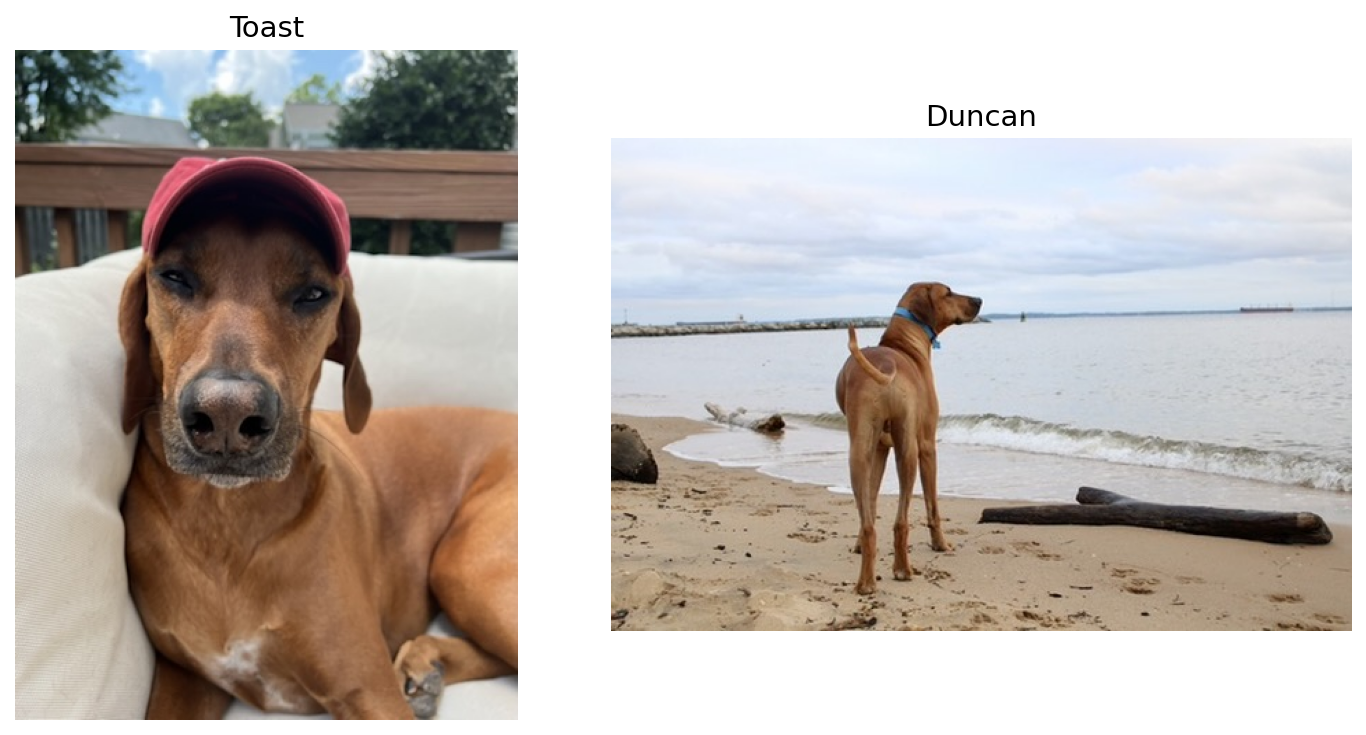

In [ ]:
def get_random_photo(dir):
    files = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    random_file = Path(dir) / random.choice(files)
    return random_file

def show_side_by_side(toast_path, duncan_path):
    toast_img = Image.open(toast_path)
    duncan_img = Image.open(duncan_path)

    # Convert to RGB (in case image is RGBA or grayscale)
    toast_img = toast_img.convert("RGB")
    duncan_img = duncan_img.convert("RGB")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

    axes[0].imshow(toast_img)
    axes[0].set_title("Toast", fontsize=14)
    axes[0].axis("off")

    axes[1].imshow(duncan_img)
    axes[1].set_title("Duncan", fontsize=14)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

random_toast = get_random_photo("photos/toast")
random_duncan = get_random_photo("photos/duncan")

show_side_by_side(random_toast, random_duncan)

#### Train, Val, and Test Sets

To create training, validation, and test sets, I randomly split the images in each class folder (`toast` and `duncan`) within the `photos` directory into an 80/10/10 ratio, moving the images to the corresponding subdirectories under `dataset/train/`, `dataset/val/`, and `dataset/test/`. This ensures each split is representative of both classes while maintaining a clear directory structure for model development and evaluation.

In [59]:
def split_dataset(
    src_dir="photos", 
    output_dir="dataset", 
    output_subdirs=("train", "val", "test"), 
    splits=(0.8, 0.1, 0.1), 
    seed=42
):
    assert sum(splits) == 1.0  # Splits must sum to 1.0
    random.seed(seed)
    classes = os.listdir(src_dir)

    for cls in classes:
        cls_dir = Path(src_dir) / cls
        images = list(cls_dir.glob("*"))
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * splits[0])
        n_val = int(n_total * splits[1])

        split_images = {
            "train": images[:n_train],
            "val": images[n_train:n_train + n_val],
            "test": images[n_train + n_val:]
        }

        for split_name in output_subdirs:
            dst_dir = Path(output_dir) / split_name / cls
            dst_dir.mkdir(parents=True, exist_ok=True)

            for image_path in split_images[split_name]:
                shutil.copy(str(image_path), str(dst_dir / image_path.name))

            print(f"Moved {len(split_images[split_name])} photos to {dst_dir}.")


split_dataset()

Moved 160 photos to dataset/train/toast.
Moved 20 photos to dataset/val/toast.
Moved 21 photos to dataset/test/toast.
Moved 160 photos to dataset/train/duncan.
Moved 20 photos to dataset/val/duncan.
Moved 21 photos to dataset/test/duncan.


#### Summary Statistics

Look at the distribution of images sizes and check for corrupted files.

In [92]:
def get_sizes(dir="dataset"):
    images = []
    for folder, subfolders, filenames in os.walk(dir):
        for image in filenames:
            if image.lower().endswith((".jpg", ".jpeg")):
                images.append(folder + "/" + image)

    sizes = []
    rejected = []
    for item in images:
        try:
            with Image.open(item) as img:
                sizes.append(img.size)
        except:
            rejected.append(item)

    print(f"{len(rejected)} files could not be opened.")
    return sizes


sizes = get_sizes()
df = pd.DataFrame(sizes, columns=["width", "height"])

0 files could not be opened.


In [72]:
df["width"].describe()

count    400.000000
mean     393.340000
std       55.556554
min      358.000000
25%      360.000000
50%      360.000000
75%      480.000000
max      574.000000
Name: width, dtype: float64

In [73]:
df["height"].describe()

count    400.000000
mean     450.137500
std       68.326751
min      359.000000
25%      360.000000
50%      480.000000
75%      480.000000
max      778.000000
Name: height, dtype: float64

Let's resize the shorter side to 360 pixels, which is the smaller median across the dataset. This avoids upsampling most images while still providing enough space for a center crop.

Note that ResNet was trained on 224 by 224 pixel images, but we don't have to match that size for fine-tuning because CNNs are spatially flexible:
- Convolutions slide across the input and don’t require a fixed input size. That’s unlike fully connected layers or matrix-multiplied embeddings (like NLP transformers), which do require fixed input shapes.
- ResNet downscales feature maps using stride and pooling, but it can do so on any reasonably sized input as long as the final spatial dimension is big enough to be pooled.
- PyTorch’s ResNet implementation ends with `nn.AdaptiveAvgPool2d((1, 1))`. This layer reduces any spatial dimension to 1×1, regardless of input size, making it safe to follow with a fully connected classifier.

#### Transform and Load

- `transforms.Lambda(ImageOps.exif_transpose)`: Corrects the image orientation based on EXIF metadata from iPhones.  
- `transforms.RandomRotation(degree)`: 
    - Applies a random rotation to the image by up to ±`degree` degrees during training.
    - Not currently doing this because the dataset already has a good distribution of realistic angles.
- `transforms.Resize(size)`: Resizes the shorter side to `size` while preserving aspect ratio.  
- `transforms.CenterCrop(size)`: Crops out a region of the specified size from the center of the image.
- `transforms.ToTensor()`:  
    - Converts a PIL image with pixel values in [0, 255] to a PyTorch tensor with values in [0.0, 1.0]  
    - Also rearranges the shape from [H, W, C] to [C, H, W], which is the shape PyTorch expects  
- `transforms.Normalize(mean, std)`: 
    - Standardizes the image by adjusting each color channel to have a mean of 0 and a standard deviation of 1, based on predefined values. This ensures the input distribution matches what the pretrained model (ResNet) was trained on, helping it make accurate predictions and improving training stability.  
    - `x_new = (x - mean) / std`

In [ ]:
# The channel-wise mean and standard deviation that were used to normalize images for ResNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Lambda(ImageOps.exif_transpose),
    transforms.Resize(360),
    transforms.CenterCrop(320),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Can use the same transform for train, test, and val since we're not doing augmentation
test_transform = val_transform = train_transform

`datasets.ImageFolder` treats any folder in `dataset/train` as a separate class, sends every image through the transform, and returns a `torch.utils.data.Dataset` object with:
- Images as tensors
- Integer class labels based on folder names
- Automatically maps classes to indices (e.g., {duncan: 0, toast: 1})

In [75]:
train_data = datasets.ImageFolder("dataset/train", transform=train_transform)
val_data = datasets.ImageFolder("dataset/val", transform=val_transform)
test_data = datasets.ImageFolder("dataset/test", transform=test_transform)

class_names = train_data.classes
print(class_names)

['duncan', 'toast']


Check that images were resized correctly:

In [84]:
img, label = train_data[0]
print(f"Image shape: {img.shape}")
print(f"Image label: {train_data.classes[label]}") 

Image shape: torch.Size([3, 320, 320])
Image label: duncan


In [89]:
batch_size = 10

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

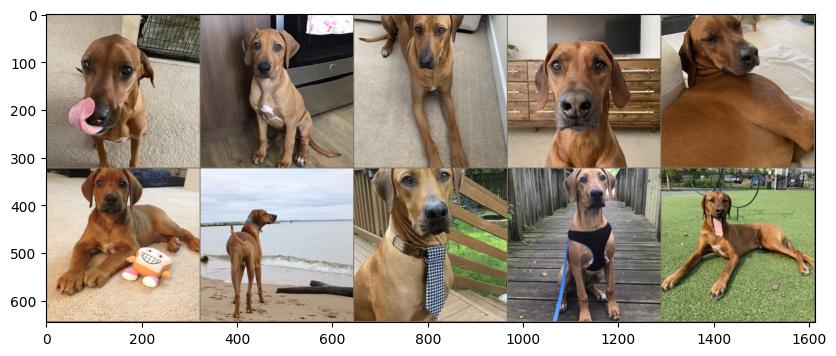

In [91]:
# Grab a sample batch
for images, labels in train_loader:
    break

image_grid = make_grid(images, nrow=5)

# Reverse the normalization so that the images look normal
inverse_normalize = transforms.Normalize(
    mean=[-m/s for m,s in zip(mean, std)],
    std=[1/s for s in std]
)
inverse_grid = inverse_normalize(image_grid)

plt.figure(figsize=(12, 4))
plt.imshow(np.transpose(inverse_grid.numpy(), (1,2,0)))

#### Training

- Transfer learning on ResNet18, freezes model weights with new classifier head
- Reduces learning rate if validation loss hasn't decreased in a certain number of epochs
- Stop learning when validation loss plateaus

In [114]:
def train(
    model,
    train_loader,
    val_loader,
    num_epochs=20,
    lr=0.001,
    patience=5
):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,    
        mode="min",   # You're watching for a minimum in the monitored metric (val loss)
        factor=0.5,   # Multiply the learning rate by this factor when triggered (e.g., 0.001 → 0.0005)
        patience=2    # Wait this many epochs with no improvement before reducing LR
    )

    train_losses = []
    val_losses = []
    train_acc_list = []
    val_acc_list = []

    best_val_loss = float("inf")
    epochs_without_improvement = 0

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0

        # Training
        for X_train, y_train in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_train)  # Returns shape [batch_size, num_classes] with logits for each class
            loss = criterion(y_pred, y_train)
            loss.backward()   # Compute gradients for all params
            optimizer.step()  # Update weights based on gradients and learning rate

            train_loss += loss.item()
            predicted = torch.argmax(y_pred, dim=1)  # Gets argmax along the class dimension
            train_correct += (predicted == y_train).sum().item()

        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * train_correct / len(train_loader.dataset)
        train_losses.append(train_loss_avg)
        train_acc_list.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                y_pred = model(X_val)
                loss = criterion(y_pred, y_val)

                val_loss += loss.item()
                predicted = torch.argmax(y_pred, dim=1)
                val_correct += (predicted == y_val).sum().item()

        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss_avg)
        val_acc_list.append(val_acc)

        # Compares val_loss_avg to the best previously seen loss.
        # If the loss hasn’t improved for a number of epochs (patience), it
        # reduces the learning rate by multiplying it by factor.
        scheduler.step(val_loss_avg)

        print(
            f"Epoch {epoch + 1}/{num_epochs} | "
            f"Train Loss: {train_loss_avg:.4f}, Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss_avg:.4f}, Acc: {val_acc:.2f}%"
        )

        # Early stopping
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping after {epoch + 1} epochs.")
                break

    total_time = time.time() - start_time
    print(f"\nTraining complete in {total_time:.2f} seconds.")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_acc": train_acc_list,
        "val_acc": val_acc_list,
        "model": model
    }

In [115]:
# Load pretrained model
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

results = train(model, train_loader, val_loader)

Epoch 1/20 | Train Loss: 0.6984, Acc: 60.06% | Val Loss: 0.5711, Acc: 82.50%
Epoch 2/20 | Train Loss: 0.5486, Acc: 72.96% | Val Loss: 0.5122, Acc: 80.00%
Epoch 3/20 | Train Loss: 0.5152, Acc: 72.96% | Val Loss: 0.4675, Acc: 80.00%
Epoch 4/20 | Train Loss: 0.4145, Acc: 85.53% | Val Loss: 0.4234, Acc: 85.00%
Epoch 5/20 | Train Loss: 0.4290, Acc: 80.50% | Val Loss: 0.5637, Acc: 67.50%
Epoch 6/20 | Train Loss: 0.3768, Acc: 82.08% | Val Loss: 0.4347, Acc: 80.00%
Epoch 7/20 | Train Loss: 0.4045, Acc: 80.19% | Val Loss: 0.3737, Acc: 82.50%
Epoch 8/20 | Train Loss: 0.3400, Acc: 88.68% | Val Loss: 0.4429, Acc: 80.00%
Epoch 9/20 | Train Loss: 0.3019, Acc: 89.94% | Val Loss: 0.3528, Acc: 90.00%
Epoch 10/20 | Train Loss: 0.3148, Acc: 88.68% | Val Loss: 0.4305, Acc: 82.50%
Epoch 11/20 | Train Loss: 0.3616, Acc: 86.48% | Val Loss: 0.3907, Acc: 87.50%
Epoch 12/20 | Train Loss: 0.2926, Acc: 88.99% | Val Loss: 0.4218, Acc: 82.50%
Epoch 13/20 | Train Loss: 0.2697, Acc: 90.88% | Val Loss: 0.3464, Acc: 80

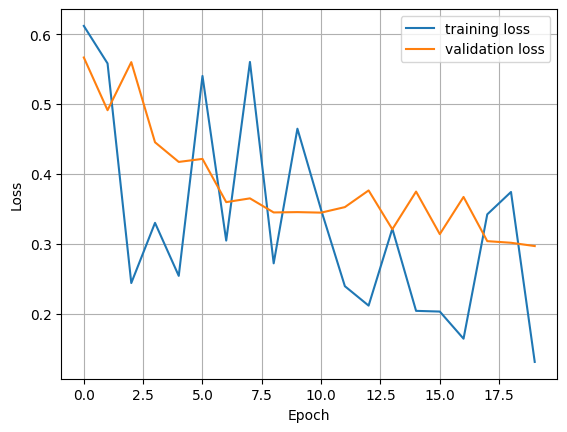

In [120]:
plt.plot([loss.item() for loss in train_losses], label="training loss")
plt.plot([loss.item() for loss in val_losses], label="validation loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

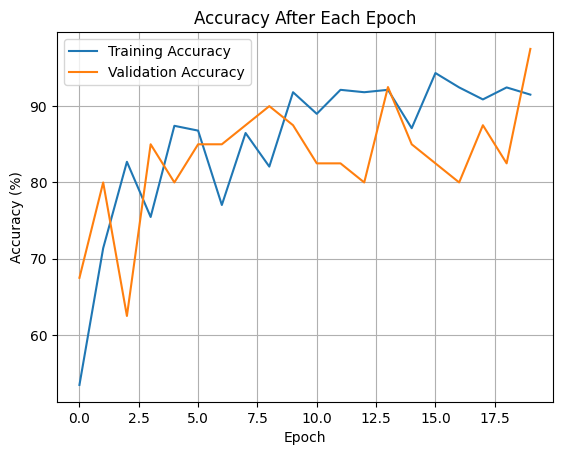

In [121]:
plt.plot(
    [correct * 100 / len(train_loader.dataset) for correct in train_correct_list],
    label="Training Accuracy"
)
plt.plot(
    [correct * 100 / len(val_loader.dataset) for correct in val_correct_list],
    label="Validation Accuracy"
)
plt.title("Accuracy After Each Epoch")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

#### Evaluation

In [133]:
def evaluate(model, test_loader, device=None):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_test, y_test in test_loader:
            y_pred = model(X_test)
            predicted = torch.argmax(y_pred, dim=1)
            correct += (predicted == y_test).sum().item()
            total += y_test.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [134]:
accuracy = evaluate(model, test_loader)

Test Accuracy: 92.86%


#### Visualize

In [154]:
def show_test_predictions(model, test_loader, class_names, num_images=8):
    model.eval()
    fig = plt.figure(figsize=(16, 4))
    X_test, y_test = next(iter(test_loader))

    # Make sure we don’t request more images than available
    num_images = min(num_images, X_test.size(0))
    indices = random.sample(range(X_test.size(0)), num_images)
    X_sample = X_test[indices]
    y_sample = y_test[indices]

    with torch.no_grad():
        y_pred = model(X_sample)
        predicted = torch.argmax(y_pred, dim=1)

    for i in range(num_images):
        image = to_pil_image(inverse_normalize(X_sample[i]))
        true_label = class_names[y_sample[i].item()]
        pred_label = class_names[predicted[i].item()]
        title = f"True: {true_label}\nPred: {pred_label}"

        ax = plt.subplot(1, num_images, i + 1)
        ax.imshow(image)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

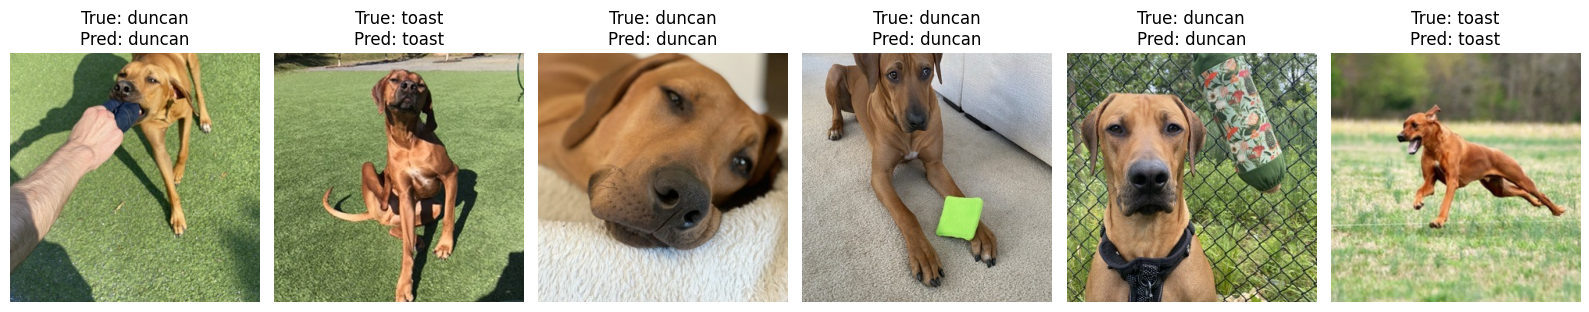

In [159]:
show_test_predictions(model, test_loader, class_names, num_images=6)

#### Save Model

In [160]:
torch.save(model.state_dict(), "toast_vs_duncan_weights.pth")

#### Reload Model

In [ ]:
# Reconstruct the architecture
model = resnet18(weights=None)  # Use weights=None to avoid loading ImageNet weights again
model.fc = nn.Linear(model.fc.in_features, 2)  # Match your final classifier

# Load the trained weights
model.load_state_dict(torch.load("toast_vs_duncan_weights.pth"))
model.eval()